# 4. Timing analysis

We will produce a light curve of PKS 2155-304 in two energy bands, compute the ratio of the fluxes and see if there is any hint of spectral variability. Based on this we will build a model based on two distinct time components and try to characterize their spectral and temporal properties.


In [1]:
import matplotlib.pyplot as plt

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from astropy.table import Table

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import (
    DatasetsMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
)
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True

from gammapy.visualization import plot_spectrum_datasets_off_regions

from regions import CircleSkyRegion

We first load the relevant data set:

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

We select a sub-sample of data acquired on our source:

In [3]:
target = SkyCoord(329.71693826 * u.deg, -30.2255890 * u.deg, frame="icrs")
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target.ra,
    lat=target.dec,
    radius="2 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

obs_ids = selected_obs_table["OBS_ID"]

observations = data_store.get_observations(obs_ids)

Obs Id:   0%|          | 0/21 [00:00<?, ?it/s]

Let's create a time intervals, for later use, and filter the observations on it:

In [4]:
t0 = Time("2006-07-29T20:30")
duration = 10 * u.min
n_time_bins = 35
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]
print(time_intervals[0].mjd)

short_observations = observations.select_time(time_intervals)

[53945.85416667 53945.86111111]


In [5]:
len(short_observations)

44

# Data reduction

Let's perform a 1D analysis of the data.

In [6]:
on_region_radius = Angle("0.11 deg")

on_region = CircleSkyRegion(center=target, radius=on_region_radius)
exclusion_region = CircleSkyRegion(center=target,radius=0.5 * u.deg)
geom = WcsGeom.create(
    npix=(120, 120), binsz=0.05, skydir=target, proj="TAN", frame="icrs"
)
exclusion_mask = ~geom.region_mask([exclusion_region])

In [7]:
energy_axis =  MapAxis.from_energy_bounds(0.1, 30, nbin=5, per_decade=True, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.05, 50, nbin=10, per_decade=True, unit="TeV", name="energy_true")

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "edisp"])

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [8]:
datasets = Datasets()

for obs in pbar.progress_bar(short_observations):
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

  0%|          | 0/44 [00:00<?, ?it/s]

In [9]:
dataset_stack = datasets.stack_reduce()

Let's find some energy at which to slice our data, to build two well-balanced sets into two energy bands:

# Fit overall spectrum

In [10]:
spectral_model = PowerLawSpectralModel()

In [11]:
source = SkyModel(spectral_model=spectral_model, name="pks 2155")
dataset_stack.models = source

In [12]:
%%time
fit_stack = Fit()
result_stack = fit_stack.run(datasets=[dataset_stack])

CPU times: user 109 ms, sys: 5.39 ms, total: 114 ms
Wall time: 112 ms


In [13]:
print(result_stack)
display(result_stack.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 150
	total stat : 587.55

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,link,prior
str8,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
pks 2155,,index,3.1802e+00,,1.571e-02,nan,nan,False,,
pks 2155,,amplitude,1.0289e-10,TeV-1 s-1 cm-2,1.564e-12,nan,nan,False,,
pks 2155,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,,


In [14]:
print(f"Pivot energy of the PL model:{source.spectral_model.pivot_energy}")

# define energy close to pivot as reference energy
source.spectral_model.reference.quantity = np.round(source.spectral_model.pivot_energy,1)

Pivot energy of the PL model:0.47141344564148185 TeV


In [15]:
result_stack_pivot = fit_stack.run(datasets=[dataset_stack])
display(result_stack_pivot.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,link,prior
str8,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
pks 2155,,index,3.1802e+00,,1.571e-02,nan,nan,False,,
pks 2155,,amplitude,9.3259e-10,TeV-1 s-1 cm-2,8.956e-12,nan,nan,False,,
pks 2155,,reference,5.0000e-01,TeV,0.000e+00,nan,nan,True,,


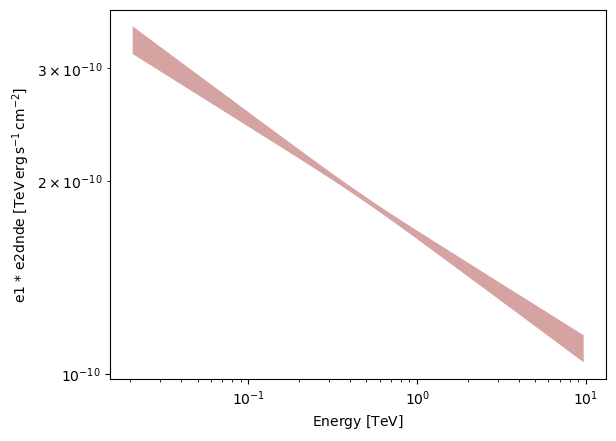

In [16]:
for result, color in zip([result_stack, result_stack_pivot], ["black", "red"]):
    spec_model = result.models[0].spectral_model
    spec_model.plot_error(energy_bounds=[20*u.GeV, 10*u.TeV], sed_type="e2dnde", energy_power=1, facecolor=color)

### Checking fit quality

Is the fit good?

Let's look at the overall fit statistic and residuals.

If number of counts per bins is large enough. WStat can provide an indicator of goodness of fit as it is asymptotically distributed as a chi-square with nbins - n free parameters dof.  

In [17]:
ndof = np.sum(dataset_stack.mask) - 2
red_wstat = result_stack_pivot.total_stat /ndof

print(f"Reduced WStat is {red_wstat} for {ndof} d.o.f.")

Reduced WStat is 65.28387654862206 for 9 d.o.f.


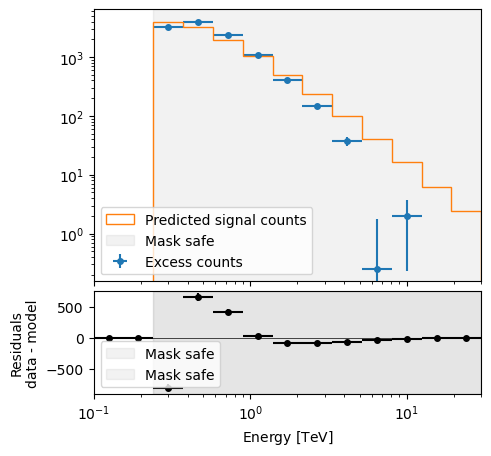

In [18]:
plt.figure(figsize=(5,5))
_=dataset_stack.plot_fit()

### Improve the model with curved PL

Use a log-parabola model

In [19]:
lpl_source = SkyModel.create(spectral_model="lp", name="pks 2155")

# to get reasonable values we change the reference energy to 500 GeV (i.e. PL pivot energy)
lpl_source.spectral_model.reference.quantity = 0.5*u.TeV
lpl_source.spectral_model.amplitude.quantity = 1e-9/(u.TeV*u.cm**2*u.s)
lpl_source.spectral_model.alpha.quantity = 2.8


dataset_stack.models = [lpl_source]

lpl_result = fit_stack.run([dataset_stack])

display(lpl_result.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,link,prior
str8,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
pks 2155,,amplitude,1.1820e-09,TeV-1 s-1 cm-2,1.680e-11,nan,nan,False,,
pks 2155,,reference,5.0000e-01,TeV,0.000e+00,nan,nan,True,,
pks 2155,,alpha,2.8777e+00,,2.337e-02,nan,nan,False,,
pks 2155,,beta,6.3043e-01,,3.557e-02,nan,nan,False,,


Reduced WStat is 4.829988169503329 for 8 d.o.f.


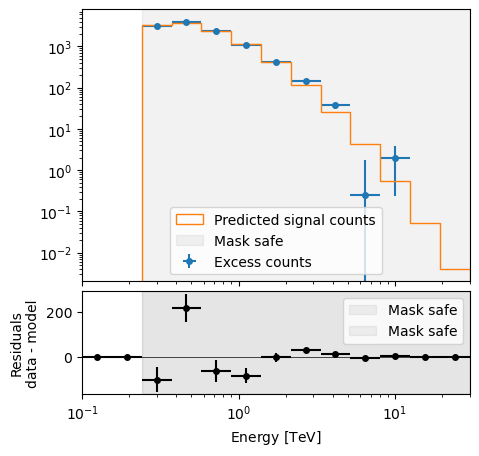

In [20]:
ndof = np.sum(dataset_stack.mask) - len(lpl_result.models.parameters.free_parameters)
red_wstat = lpl_result.total_stat /ndof

print(f"Reduced WStat is {red_wstat} for {ndof} d.o.f.")

plt.figure(figsize=(5,5))
_=dataset_stack.plot_fit()

### Improve the model taking into account EBL attenuation

Let's load precomputed EBL tables.

In [21]:
from gammapy.modeling.models import EBLAbsorptionNormSpectralModel

ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez")

ebl.redshift.value = 0.116

In [22]:
absorbed_lpl = lpl_source.spectral_model.copy() * ebl

abs_lpl_source = SkyModel(spectral_model=absorbed_lpl, name='pks 2155')

dataset_stack.models = abs_lpl_source

ebl_result = fit_stack.run([dataset_stack])
display(ebl_result.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,link,prior
str8,str1,str10,float64,str14,float64,float64,float64,bool,str1,str1
pks 2155,,amplitude,2.2273e-09,TeV-1 s-1 cm-2,3.080e-11,nan,nan,False,,
pks 2155,,reference,5.0000e-01,TeV,0.000e+00,nan,nan,True,,
pks 2155,,alpha,2.1287e+00,,2.416e-02,nan,nan,False,,
pks 2155,,beta,5.5607e-01,,3.400e-02,nan,nan,False,,
pks 2155,,redshift,1.1600e-01,,0.000e+00,nan,nan,True,,
pks 2155,,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,,


Reduced WStat is 2.21645691182686 for 8 d.o.f.


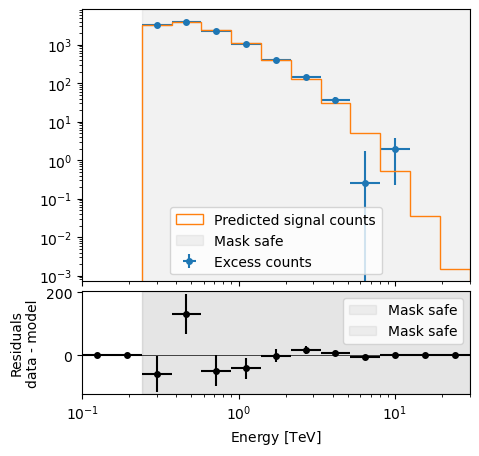

In [23]:
ndof = np.sum(dataset_stack.mask) - len(ebl_result.models.parameters.free_parameters)
red_wstat = ebl_result.total_stat /ndof

print(f"Reduced WStat is {red_wstat} for {ndof} d.o.f.")

plt.figure(figsize=(5,5))
_ = dataset_stack.plot_fit()

In [24]:
%%time

# Compute flux points
from gammapy.estimators.utils import resample_energy_edges
energy_edges = resample_energy_edges(dataset_stack, conditions={'counts_min': 5.})
print(energy_edges)

fpe = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="pks 2155",
    selection_optional=["errn-errp", "ul", "scan"],
    n_jobs=6,
)
flux_points = fpe.run([dataset_stack])

[ 0.2404892   0.37294378  0.57835055  0.89688951  1.39087062  2.15692241
  3.34489362 30.        ] TeV


Energy bins:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 146 ms, sys: 57.5 ms, total: 204 ms
Wall time: 3.98 s


Let's plot the SED so far:

(1e-14, 1e-09)

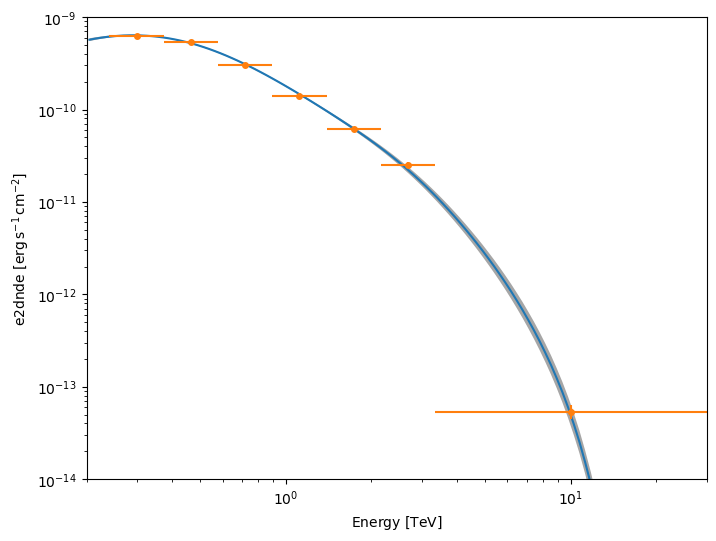

In [25]:
fig, ax = plt.subplots(figsize=(8, 6)) 

# plot joint model
abs_lpl_source.spectral_model.plot( energy_bounds=[200*u.GeV, 20*u.TeV], sed_type="e2dnde")
abs_lpl_source.spectral_model.plot_error(energy_bounds=[200*u.GeV, 20*u.TeV], sed_type="e2dnde", facecolor="grey", alpha=0.7)

ax = flux_points.plot(ax=ax,sed_type="e2dnde")
ax.set_xlim(0.2,30)
ax.set_ylim(1e-14, 1e-9)

# Light curve

Let's compute the light curve in two energy ranges

In [26]:
datasets.models = [abs_lpl_source]

In [27]:
lc_maker = LightCurveEstimator(energy_edges=[300*u.GeV, 700*u.GeV, 20*u.TeV],
                               source=0,
                               time_intervals=time_intervals,
                               selection_optional=["errn-errp", "ul", "sensitivity"],
                               n_jobs=6,
                              )
lc = lc_maker.run(datasets)

Time intervals selection:   0%|          | 0/34 [00:00<?, ?it/s]

Time intervals:   0%|          | 0/34 [00:00<?, ?it/s]

Plot the light curves:

<Axes: xlabel='Time [mjd]', ylabel='flux [$\\mathrm{s^{-1}\\,cm^{-2}}$]'>

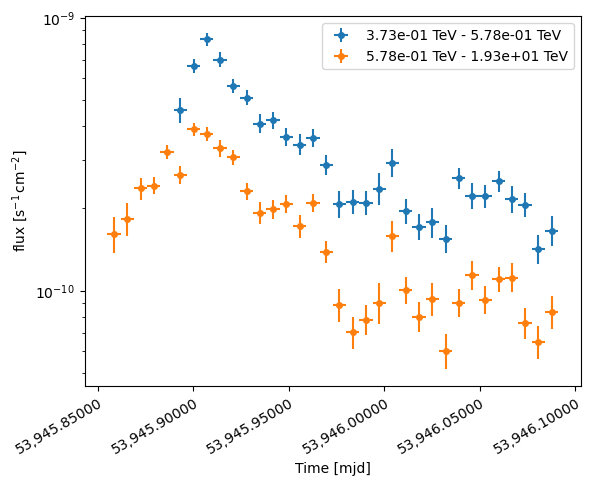

In [28]:
lc.plot(sed_type="flux", time_format="mjd", axis_name="time")

# Fractional and point-to-point variability

In [29]:
# Compute the global fractional variability, for each energy intervals

In [30]:
# Compute the point-to-point fractional variability, for each energy intervals

In [31]:
# Compute the characteristic doubling time of the light curves, for each energy intervals

# Hardness ratio diagrams

Let's compute the flux ratio of our two light curves, plot them against time, and against the overall flux (i.e. hardness ratio diagram).

Access the low-energy and high-energy light curves.

**Tip**: Remember that `RegionNDMap` holds quantities of `numpy.ndarray`s.

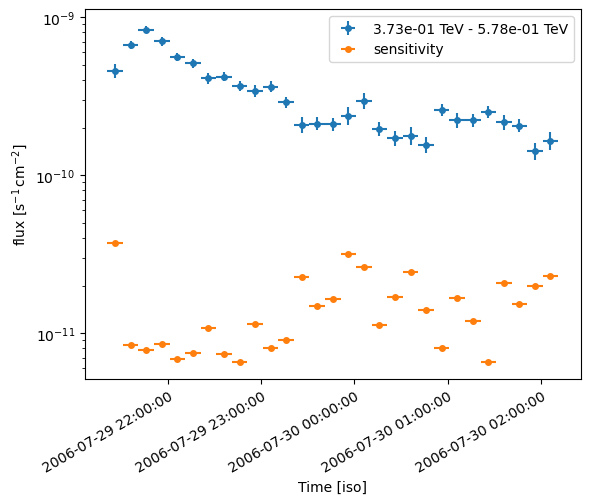

In [32]:
ax=lc.slice_by_energy(300*u.GeV, 600*u.GeV).plot(sed_type="flux")
lc.slice_by_energy(300*u.GeV, 600*u.GeV).flux_sensitivity.plot(ax=ax, label="sensitivity")
ax.legend()

In [33]:
lc_lo = lc.flux.quantity[:,0,...].squeeze()
lc_hi = lc.flux.quantity[:,1,...].squeeze()

lc_lo_err = lc.flux_err.quantity[:,0,...].squeeze()
lc_hi_err = lc.flux_err.quantity[:,1,...].squeeze()

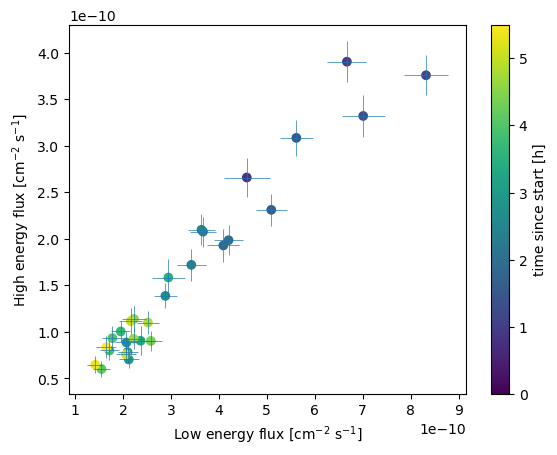

In [34]:
time = lc.geom.axes["time"].center - lc.geom.axes["time"].center[0]
plt.errorbar(x=lc_lo, y=lc_hi, xerr=lc_lo_err, yerr=lc_hi_err, linestyle='', linewidth=0.5)
plt.scatter(lc_lo, lc_hi, c=time.to_value("h"))

plt.xlabel(r'Low energy flux $[\rm cm^{-2}\ s^{-1}]$')
plt.ylabel(r"High energy flux $[\rm cm^{-2}\ s^{-1}]$")
plt.colorbar().set_label("time since start [h]")
plt.show()

In [35]:
flux_ratio = lc_hi/lc_lo
flux_ratio_err = flux_ratio * np.sqrt((lc_hi_err/lc_hi)**2+(lc_lo_err/lc_lo)**2)

Text(0, 0.5, 'Hardness ratio')

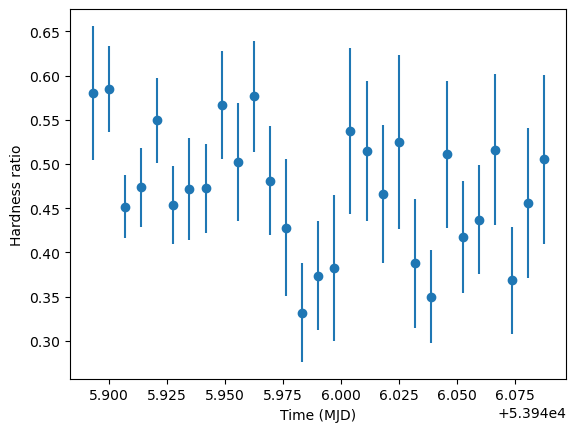

In [36]:
# Plot the flux ratio versus time

plt.errorbar(x=lc.geom.axes["time"].time_mid.mjd, y=np.squeeze(flux_ratio), yerr=np.squeeze(flux_ratio_err), fmt='o')
plt.xlabel("Time (MJD)")
plt.ylabel(f"Hardness ratio")

Now, let's plot the hardness ratio diagram (integral flux in the whole energy range, versus the flux ratio)

In [37]:
def time_resolved_spectroscopy(datasets, model, time_intervals):
    fit = Fit()
    valid_intervals = []
    fit_results = []
    index = 0
    for t_min, t_max in time_intervals:
        datasets_to_fit = datasets.select_time(time_min=t_min, time_max=t_max)

        if len(datasets_to_fit) == 0:
            print(
                f"No Dataset for the time interval {t_min} to {t_max}. Skipping interval."
            )
            continue

        model_in_bin = model.copy(name="Model_bin_" + str(index))
        datasets_to_fit.models = model_in_bin
        result = fit.run(datasets_to_fit)
        fit_results.append(result)
        valid_intervals.append([t_min, t_max])
        index += 1

    return valid_intervals, fit_results

In [38]:
abs_lpl_source.parameters["beta"].frozen=True
valid_times, results = time_resolved_spectroscopy(datasets, abs_lpl_source, time_intervals)

In [39]:
data = []
for valid_time, fit_result in zip(valid_times, results):
    result_dict = {}
    result_dict["tstart"] = valid_time[0]
    result_dict["tstop"] = valid_time[1]
    
    for par in fit_result.models[0].parameters.free_parameters:
        result_dict[par.name] = par.quantity
        result_dict[f"{par.name} error"] = par.error * par.unit

    result_dict["total_stat"] = fit_result.total_stat
    result_dict["success"] = fit_result.success

    data.append(result_dict)

table = Table(data)

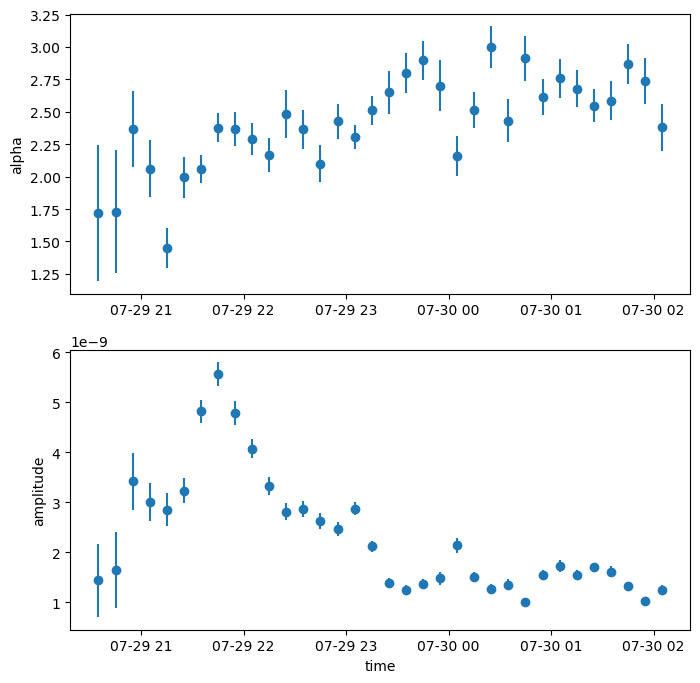

In [40]:
table = table[table["success"]==True]
from gammapy.maps import TimeMapAxis
time_axis = TimeMapAxis.from_time_edges(
    time_min=table["tstart"], time_max=table["tstop"]
)

fix, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].errorbar(
    x=time_axis.as_plot_center, y=table["alpha"], yerr=table["alpha error"], fmt="o"
)

axes[1].errorbar(
    x=time_axis.as_plot_center,
    y=table["amplitude"],
    yerr=table["amplitude error"],
    fmt="o",
)

axes[0].set_ylabel("alpha")
axes[1].set_ylabel("amplitude")
axes[1].set_xlabel("time")
plt.show()

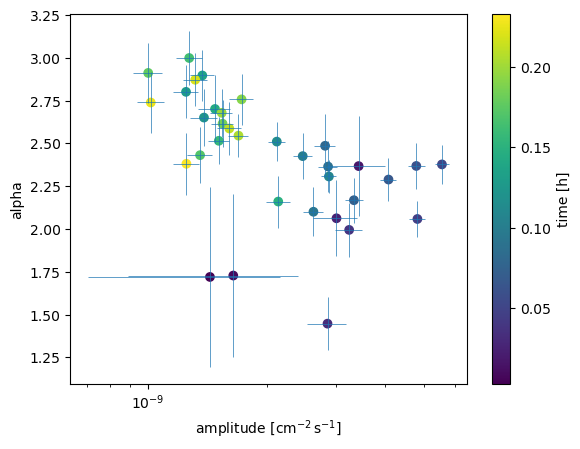

In [41]:
plt.errorbar(
    table["amplitude"],
    table["alpha"],
    xerr=table["amplitude error"],
    yerr=table["alpha error"],
    linestyle="",
    linewidth=0.5,
)
plt.scatter(table["amplitude"], table["alpha"], c=time_axis.center.value)
plt.xlabel(r"amplitude $\rm [cm^{-2}\,s^{-1}]$")
plt.ylabel("alpha")
plt.xscale("log")
plt.colorbar().set_label("time [h]")
plt.show()

## Are there different overlapping time components?

The time resolved spectroscopy supports the idea that PKS 2155-304 spectrum is harder and brighter in the first part of the night. We can distinguish two populations of points in the time resolved spectral parameters. We try to explore this idea in the following trying to fit different time and spectral components to the data.

Here we will use full sky models with time and spectral models. We will first try to see whether two separate components are required to fit the data. Then we will determine the best spectral representations for these time components.

First we introduce some convenience plotting functions to compare a model with a lightcurve.

In [42]:
def plot_compare_lc_model(ebin, lc, cst, flare, colors=["blue", "red"]):
    emin, emax = lc.geom.axes["energy"].edges_min[ebin], lc.geom.axes["energy"].edges_max[ebin]

    ax = lc.slice_by_energy(emin, emax).plot(sed_type="flux")
    ax.set_yscale("linear")
    time_values = lc.geom.axes["time"].time_mid
    xt =lc.geom.axes["time"].as_plot_center

    values = []
    for model, color in zip([cst, flare], colors):
        flux_values = model.temporal_model(time_values)*model.spectral_model.integral(emin, emax)
        ax.plot(xt, flux_values, label=model.name, color=color)
        values.append(flux_values)
        
    ax.plot(xt, values[0]+values[1], label="total", color='k')
    
    return ax

def plot_compare_spec_models(cst, flare, colors=["blue", "red"]):
    for model, color in zip([cst, flare], colors):
        ax=model.spectral_model.plot(energy_bounds=[0.2, 10]*u.TeV, sed_type="e2dnde", color=color, label=model.name)
        ax=model.spectral_model.plot_error(energy_bounds=[0.2, 10]*u.TeV, sed_type="e2dnde")
    ax.legend()

def summary_plot(lc, cst, flare):
    plt.figure(figsize=(14,4))
    ax1 = plt.subplot(131)
    plot_compare_lc_model(0, lc, cst, flare)
    ax2 = plt.subplot(132)
    plot_compare_lc_model(1, lc, cst, flare)
    ax3 = plt.subplot(133)
    plot_compare_spec_models(cst, flare)

### Are there two temporal components?

We first define two temproal models:
- a steady component modeled with a `ConstantTemporalModel`
- a flare component modeled with a `GeneralizedGaussianTemporalModel`. The latter allows for independent rise    and decay times. We set the peak time following the LC and for now freeze the parameter controling the shape   of the model.

Gammapy offers a convenience function to test nested models: `select_nested_models`.

In [43]:
from gammapy.modeling.models import GeneralizedGaussianTemporalModel, ConstantTemporalModel
from gammapy.modeling import select_nested_models

In [44]:
flare_time_model = GeneralizedGaussianTemporalModel(t_ref="53945.9 d",t_rise="0.3 h", t_decay="2 h", eta=0.5)
flare_time_model.eta.frozen=True
flare_time_model.t_rise.min=0.01
flare_time_model.t_rise.max=3
flare_time_model.t_decay.min=0.1
flare_time_model.t_decay.max=100
flare_time_model.t_ref.frozen=True

cst_time_model = ConstantTemporalModel()

In [47]:
spectral_model = abs_lpl_source.spectral_model.copy()
spectral_model.parameters["alpha"].frozen=True
spectral_model.parameters["beta"].frozen=True

cst = SkyModel(spectral_model=spectral_model.copy(), temporal_model=cst_time_model, name="steady")

flare = SkyModel(spectral_model=spectral_model.copy(), temporal_model=flare_time_model, name="flare")

In [48]:
datasets.models = [cst, flare]

In [49]:
result_two_flare = select_nested_models(
    datasets, 
    parameters=[cst.parameters["amplitude"]], 
    null_values=[0.]
)

Fit improvement : Delta TS = 874.6168325167264


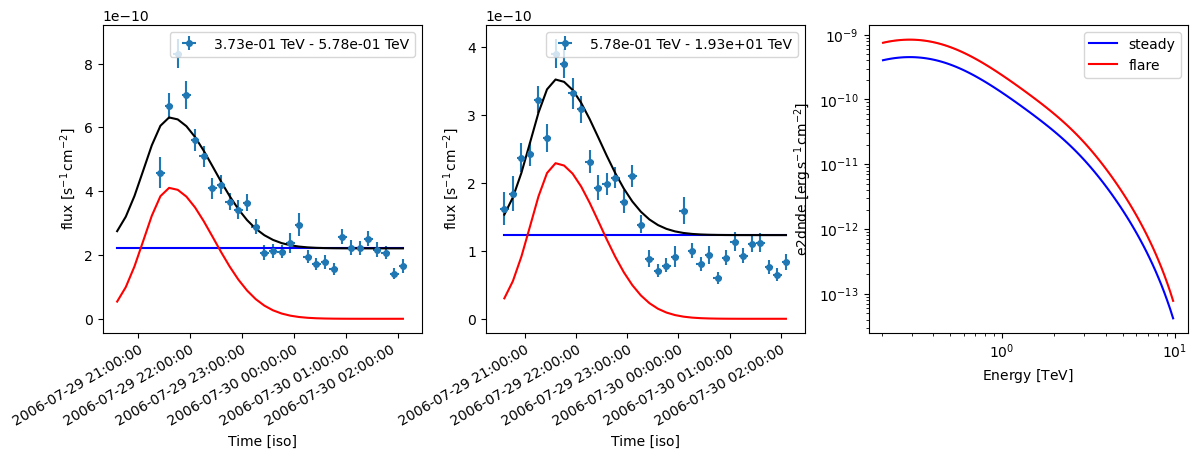

In [50]:
print(f"Fit improvement : Delta TS = {result_two_flare['ts']}")
summary_plot(lc, cst, flare)
#display(result_two_flare["fit_results"].models.to_parameters_table())

There is a very significant preference for a steady model in addition to the flare.

Let's now try to see if the spectral parameters of the flare are different from the average spectrum

Fit improvement : Delta TS = 71.12934647000111


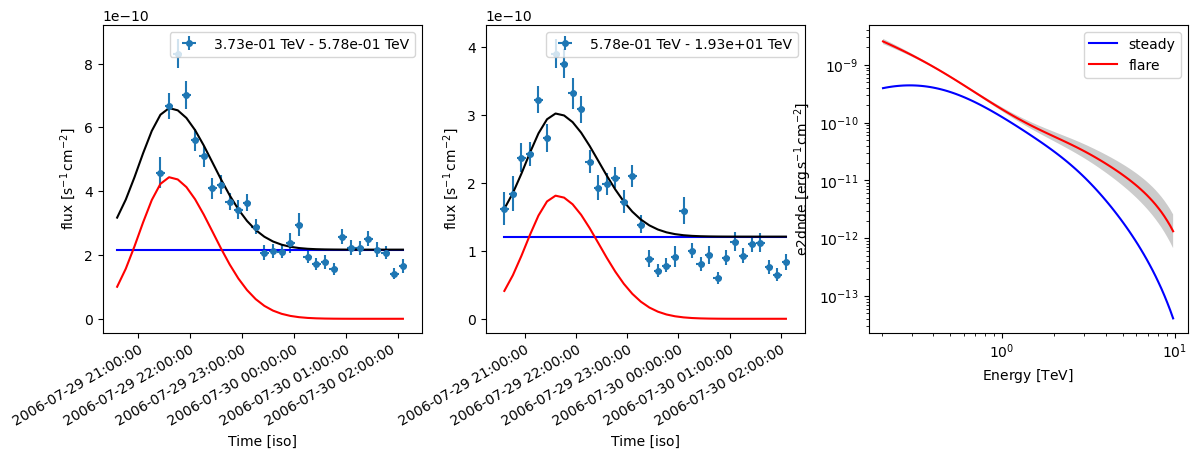

In [51]:
flare.parameters["alpha"].frozen = False
flare.parameters["beta"].frozen = False

result_two_flare = select_nested_models(
    datasets, 
    parameters=[flare.parameters["alpha"], flare.parameters["beta"]], 
    null_values=[flare.parameters["alpha"].value, flare.parameters["beta"].value]
)

print(f"Fit improvement : Delta TS = {result_two_flare['ts']}")
#display(result_two_flare["fit_results"].models.to_parameters_table())
summary_plot(lc, cst, flare)

The flare spectrum is significantly different from the average one. What about the steady component?


Fit improvement : Delta TS = 230.41997422375948


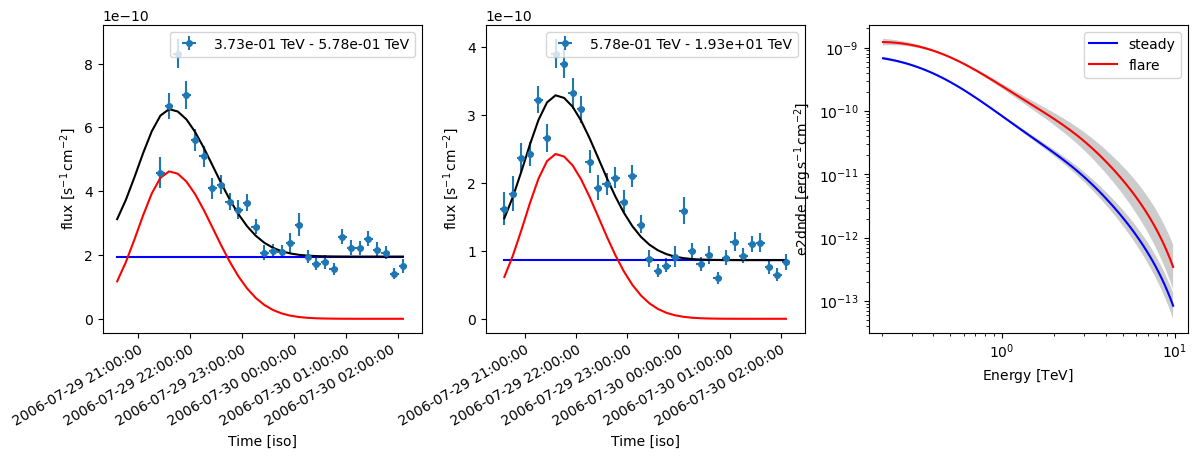

In [52]:
cst.parameters["alpha"].frozen = False
cst.parameters["beta"].frozen = False

result_two_flare = select_nested_models(
    datasets, 
    parameters=[cst.parameters["alpha"], cst.parameters["beta"]], 
    null_values=[cst.parameters["alpha"].value, cst.parameters["beta"].value]
)

print(f"Fit improvement : Delta TS = {result_two_flare['ts']}")
summary_plot(lc, cst, flare)

The comparison of the LC with the fitted model shows that the flare structure seems to be more peaked. Let's release the remaining parameters of the generalized gaussian (peak position and shape parameter).

Fit improvement : Delta TS = 12.79864467963148


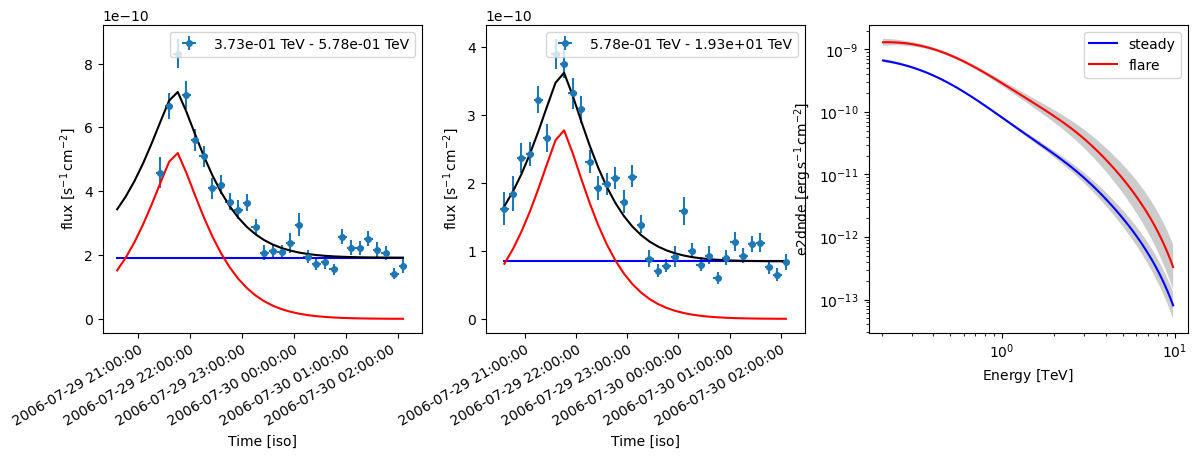

In [53]:
flare.parameters["eta"].frozen = False
flare.parameters["eta"].min = 0.1
flare.parameters["eta"].max = 3

flare.parameters["t_ref"].frozen = False
flare.parameters["t_ref"].min = flare.parameters["t_ref"].value - 0.3
flare.parameters["t_ref"].max = flare.parameters["t_ref"].value + 0.3

result_two_flare = select_nested_models(
    datasets, 
    parameters=[flare.parameters["eta"],flare.parameters["t_ref"]], 
    null_values=[flare.parameters["eta"].value,flare.parameters["t_ref"].value]
)

print(f"Fit improvement : Delta TS = {result_two_flare['ts']}")
summary_plot(lc, cst, flare)

The final model parameters are given below:

In [54]:
result_two_flare["fit_results"].models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link,prior
str6,str1,str10,float64,str14,float64,float64,float64,bool,str1,str1
steady,,amplitude,1.2829e-09,TeV-1 s-1 cm-2,3.677e-11,nan,nan,False,,
steady,,reference,5.0000e-01,TeV,0.000e+00,nan,nan,True,,
steady,,alpha,2.6689e+00,,3.705e-02,nan,nan,False,,
steady,,beta,2.7716e-01,,5.363e-02,nan,nan,False,,
steady,,redshift,1.1600e-01,,0.000e+00,nan,nan,True,,
steady,,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,,
flare,,amplitude,3.6883e-09,TeV-1 s-1 cm-2,2.028e-10,nan,nan,False,,
flare,,reference,5.0000e-01,TeV,0.000e+00,nan,nan,True,,
flare,,alpha,2.3121e+00,,1.047e-01,nan,nan,False,,


/var/folders/p2/l2vqhn_17zbghwxxwwdnvk0m0000gn/T/ipykernel_79058/1253231172.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


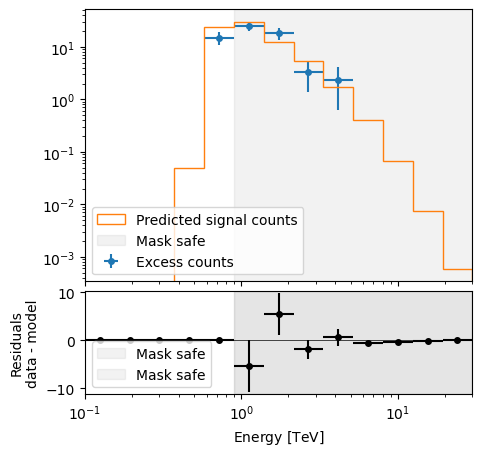

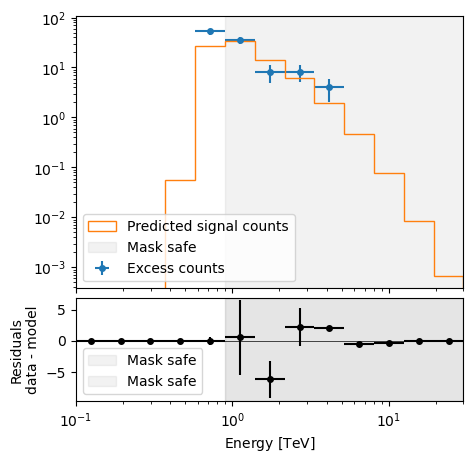

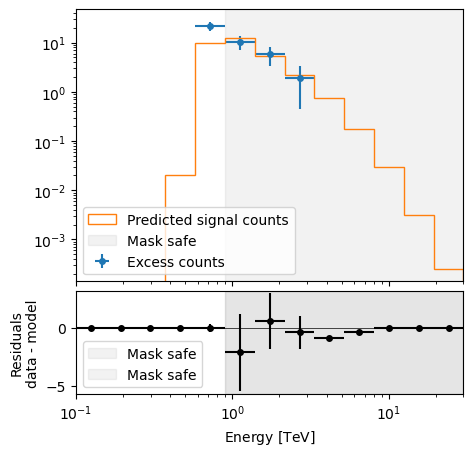

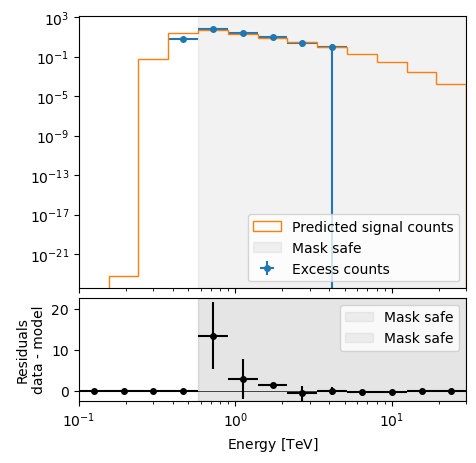

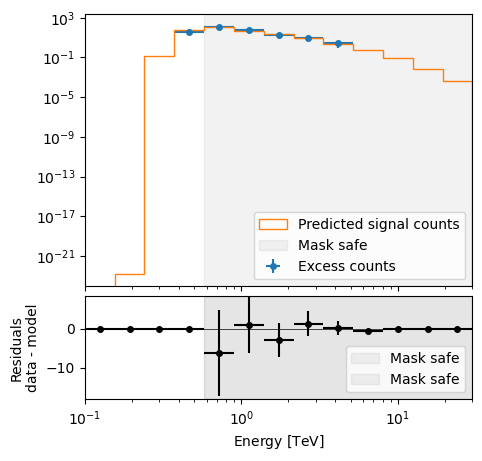

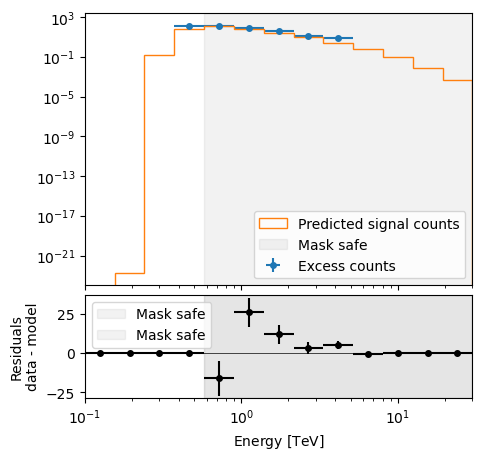

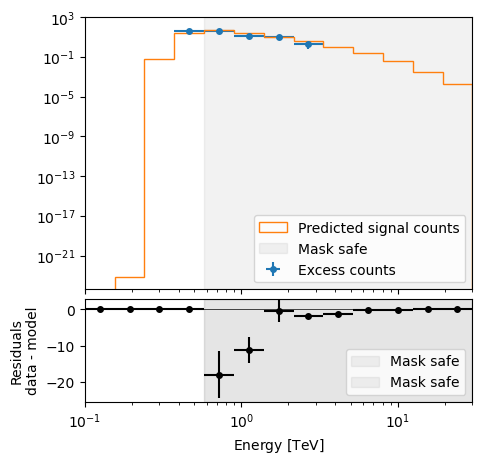

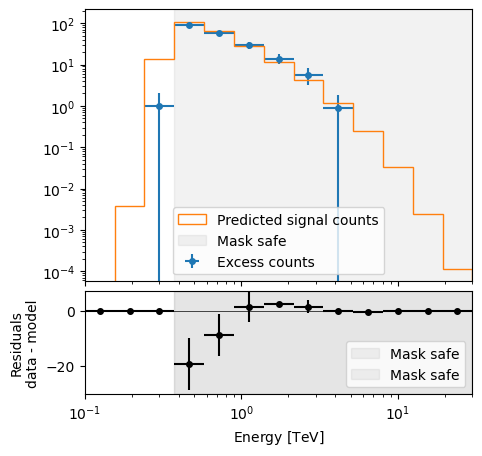

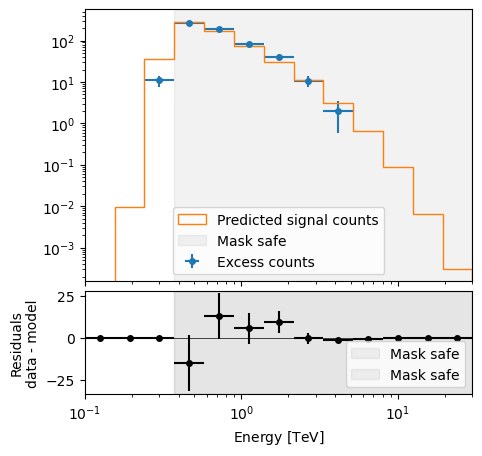

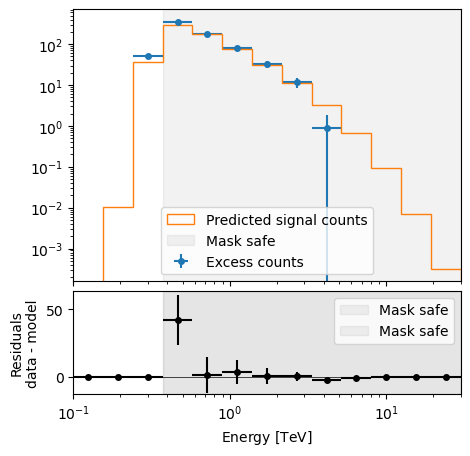

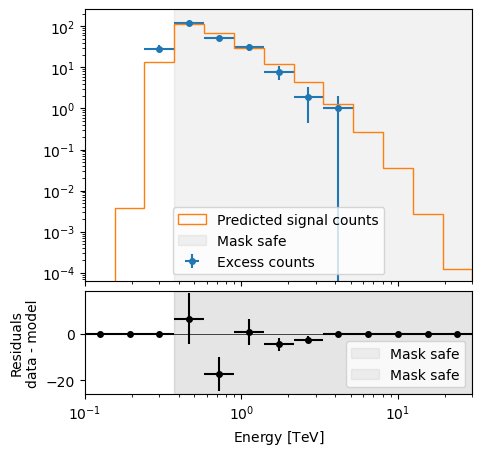

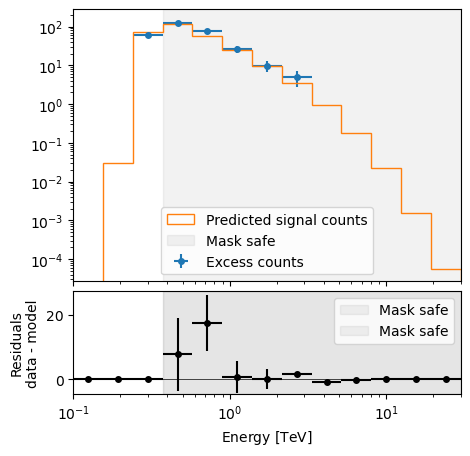

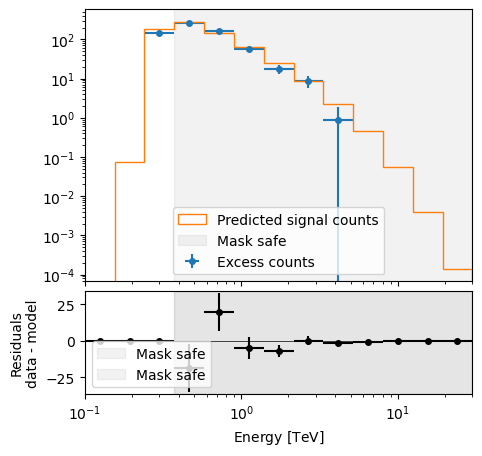

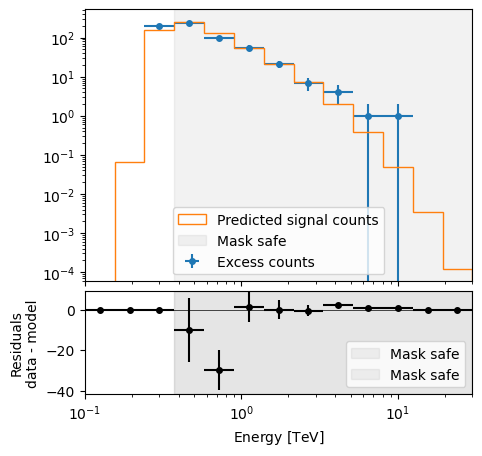

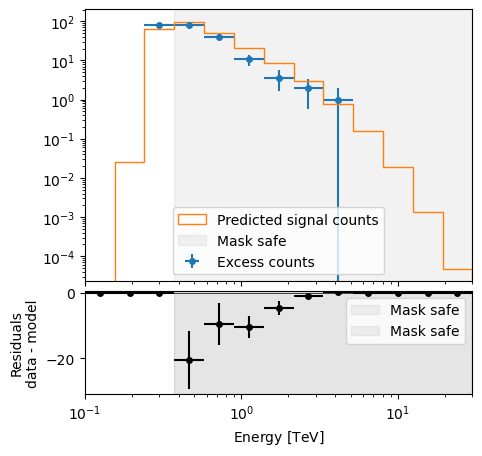

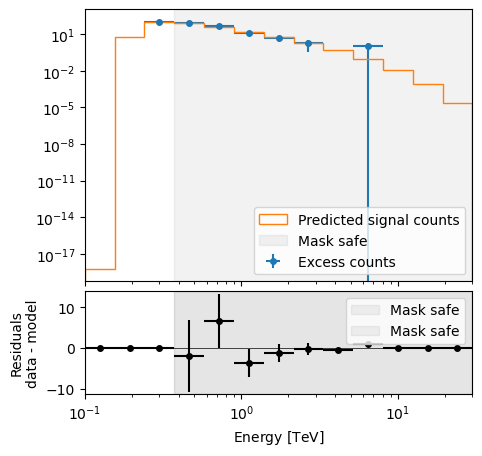

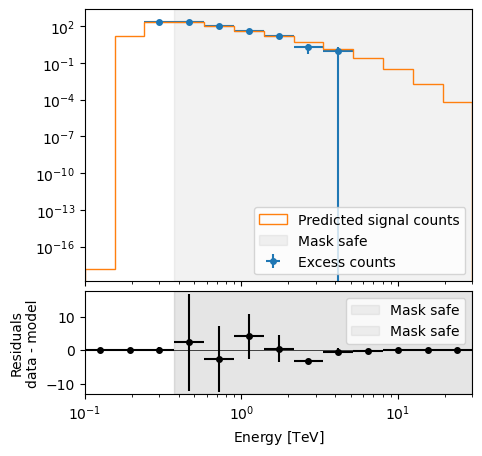

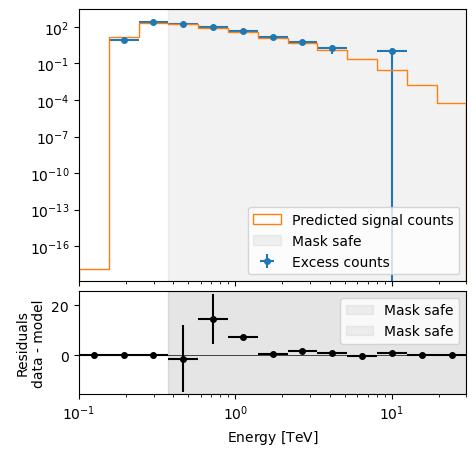

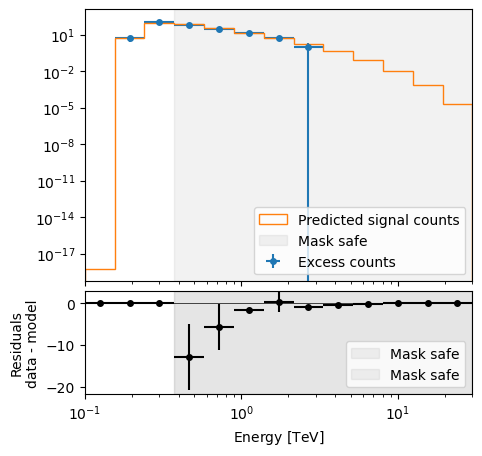

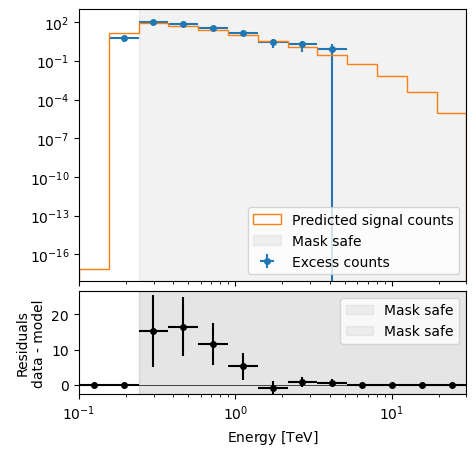

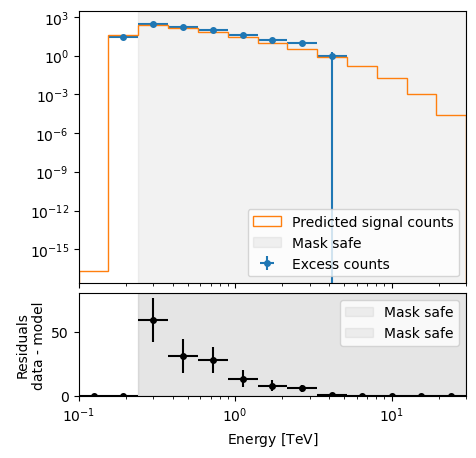

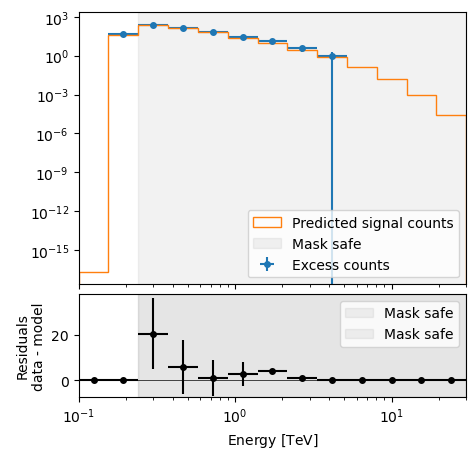

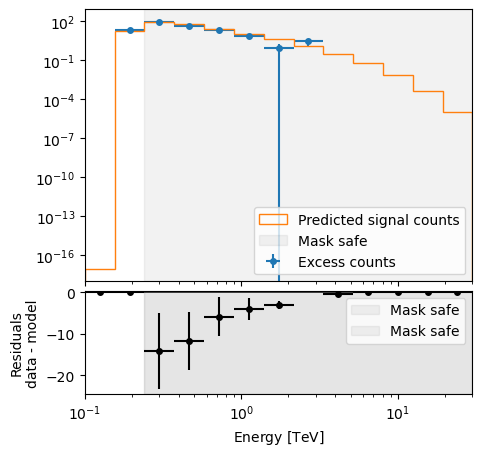

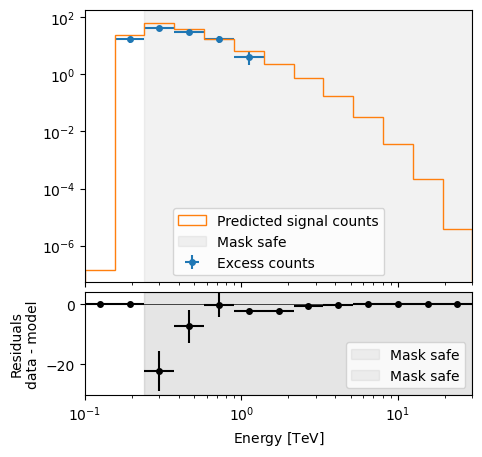

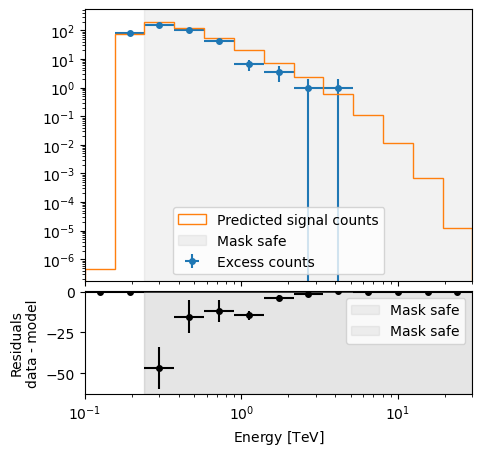

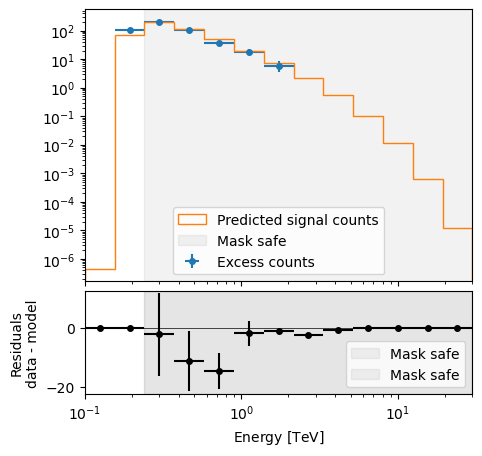

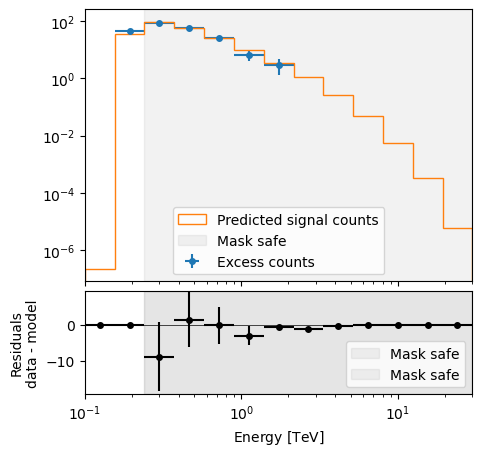

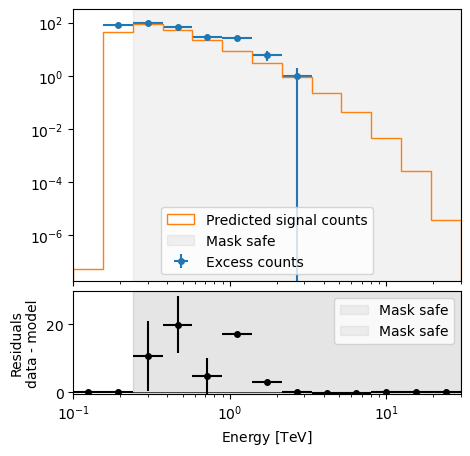

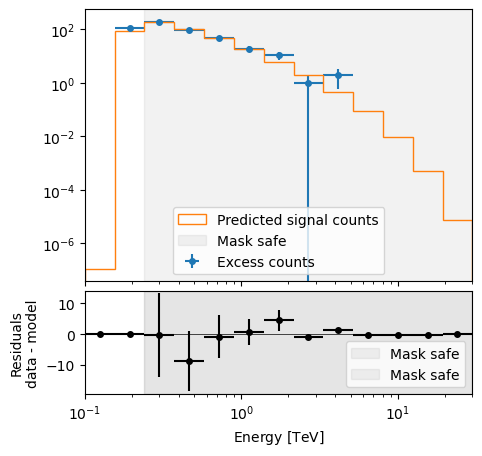

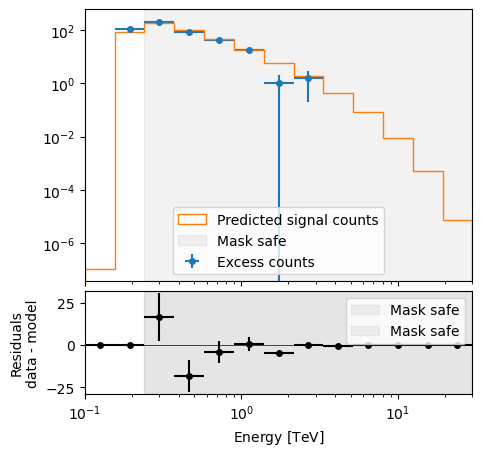

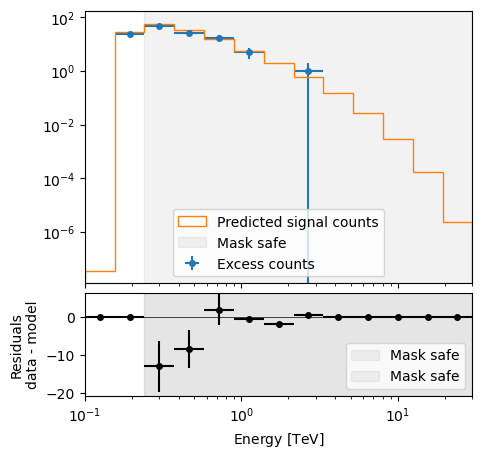

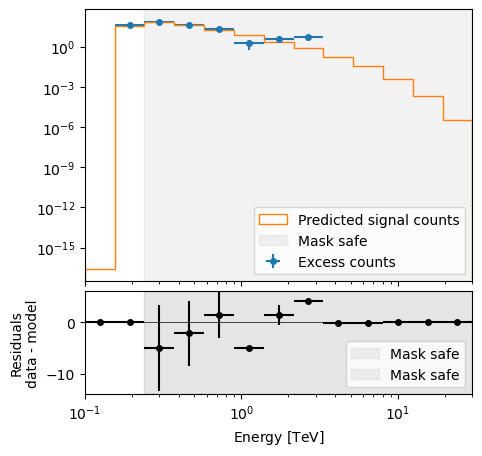

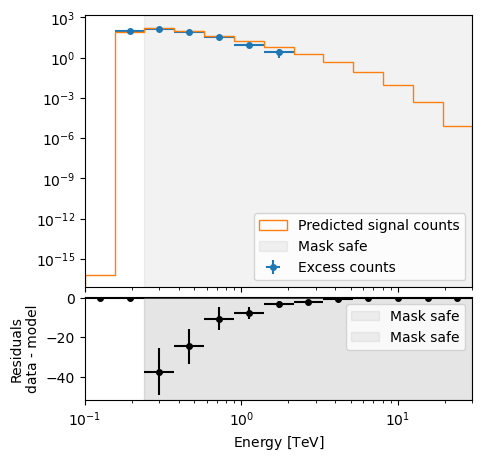

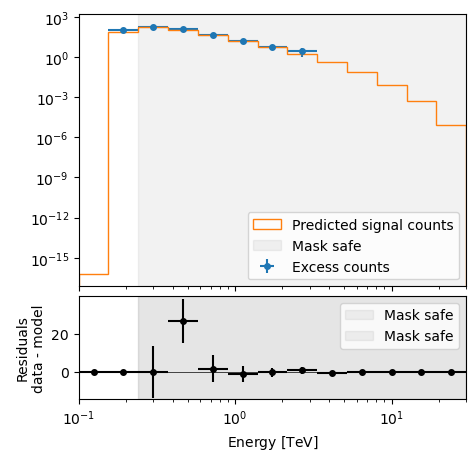

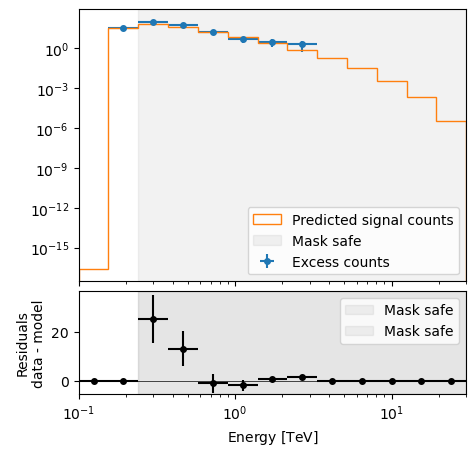

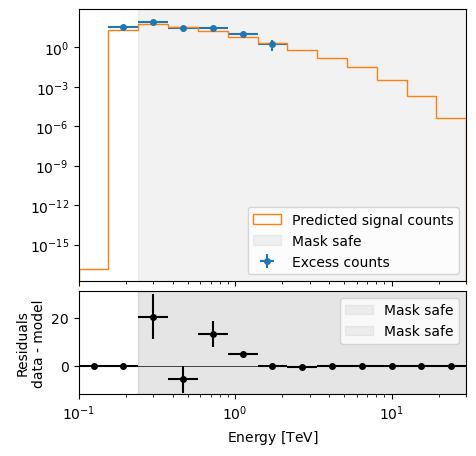

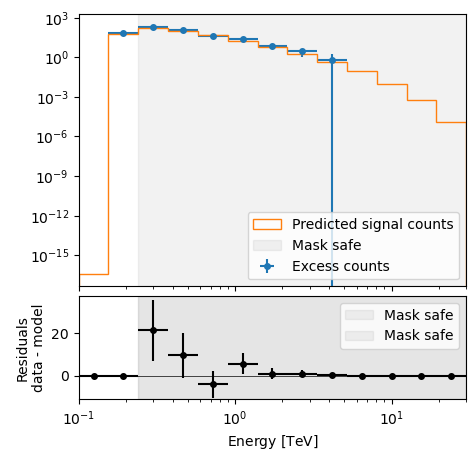

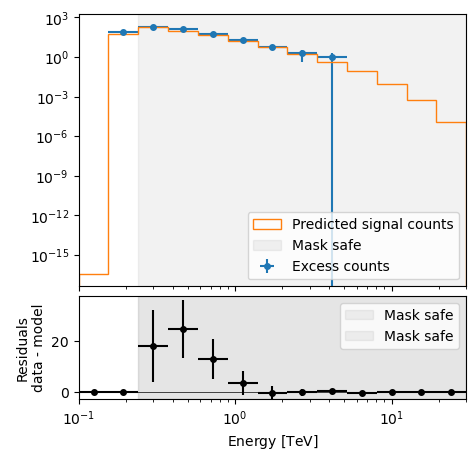

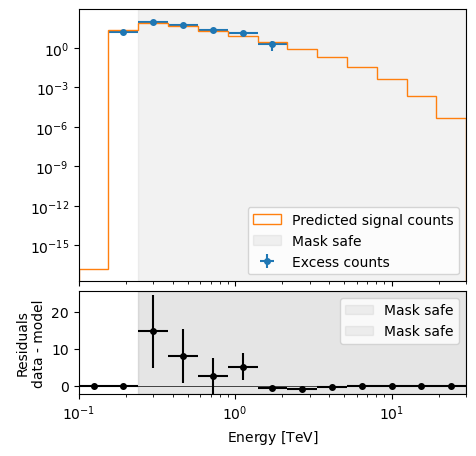

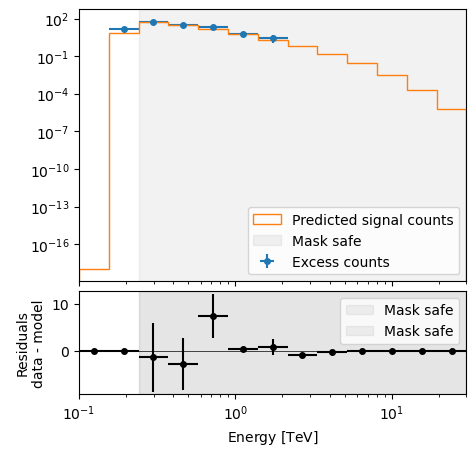

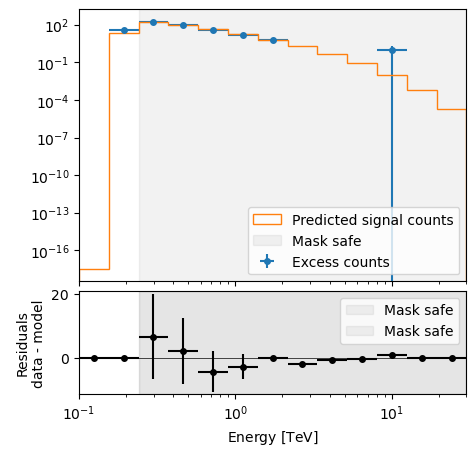

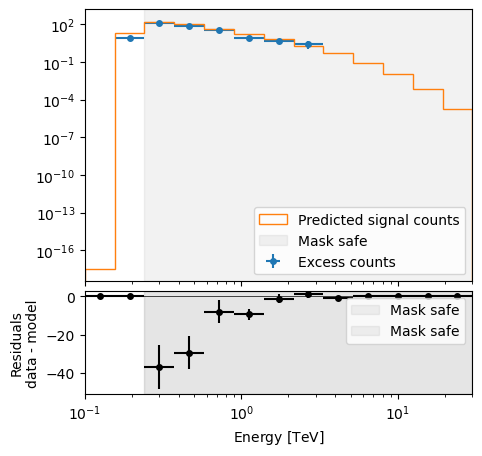

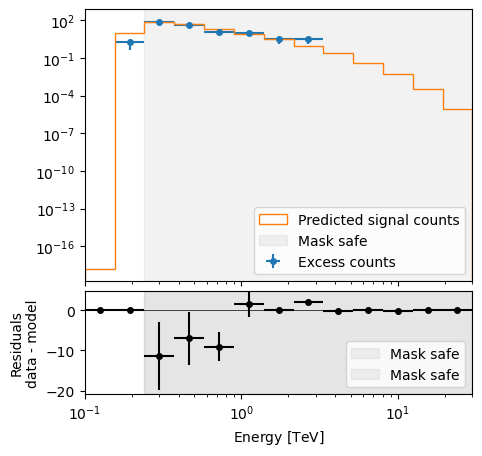

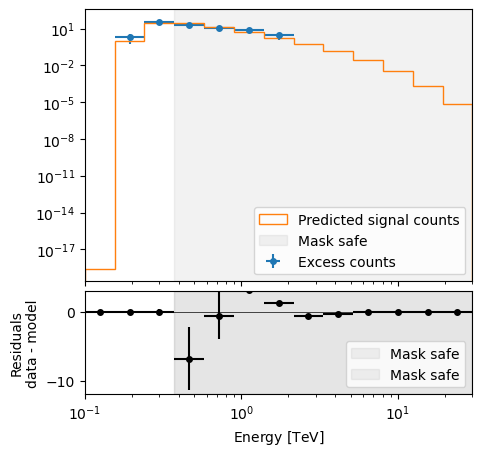

In [56]:
for time in time_intervals[]:
    plt.figure(figsize=(5,5))
    ds.plot_fit()